# Маркетинговый анализ развлекательного приложения Procrastinate Pro+

**Описание**

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

**Задача**

Провести маркетинговый анализ, разобраться в причинах неэффективной реклами и найти точки роста

**Ход проекта**

1. Загрузка данных и подготовка к анализу
2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии.
3. Исследовательский анализ данных
4. Маркетинг
5. Оцените окупаемость рекламы
6. Выводы

**Описание данных**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

* `User Id` — уникальный идентификатор пользователя
* `Device` — категория устройства пользователя
* `Session start` — дата и время начала сессии
* `Session End` — дата и время окончания сессии
* `Channel` — идентификатор рекламного источника, из которого пришел пользователь
* `Region` - страна пользователя

Таблица orders_log_short (информация о заказах):

* `User Id` — уникальный id пользователя, который сделал заказ
* `Event Dt` — дата и время покупки
* `Revenue` — выручка

Таблица costs_short (информация о затратах на маркетинг):

* `Channel` — идентификатор рекламного источника
* `Dt` — дата
* `Costs` — затраты на этот рекламный источник в этот день

## Загрузка данных и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

### Имортируем библиотеки и загружаем данные

In [4]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math


visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'),  # журнал визитов
    pd.read_csv('/datasets/orders_info.csv'),  # заказы
    pd.read_csv('/datasets/costs_info.csv')  # расходы
)

### Подготовка данных к анализу

In [22]:
# Напишем функцию для первичного вывода и изменения столбцов
def get_data(df):
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    display(df.info())
    display(df.head())
    display(df.describe())
    print('Дубликатов :', df.duplicated().sum())

In [21]:
get_data(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:00   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:00   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:00   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:00   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:00   

          session_end  
0 2019-05-01 02:45:00  
1 2019-05-01 04:47:00  
2 2019-05-01 15:32:00  
3 2019-05-01 00:54:00  
4 2019-05-01 03:57:00

user_id
count  3.099010e+05
mean   4.997664e+11
std    2.887899e+11
min    5.993260e+05
25%    2.493691e+11
50%    4.989906e+11
75%    7.495211e+11
max    9.999996e+11

Дубликатов : 0


С данными в целом все в порядке, единственно приведем столбцы с датами в нужны формат и немного поменяем название колонок.

In [23]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format="%d.%m.%Y %H:%M")
visits['session_end'] = pd.to_datetime(visits['session_end'], format="%d.%m.%Y %H:%M")

Все в порядке, переходим к orders

In [24]:
get_data(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

user_id       revenue
count  4.021200e+04  40212.000000
mean   4.990295e+11      5.370608
std    2.860937e+11      3.454208
min    5.993260e+05      4.990000
25%    2.511324e+11      4.990000
50%    4.982840e+11      4.990000
75%    7.433327e+11      4.990000
max    9.998954e+11     49.990000

Дубликатов : 0


Приведем к нужным типам, поменяем название столбцов

In [25]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format="%Y-%m-%d %H:%M:%S")

Всё нормально, двигаемся к costs

In [26]:
get_data(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000

Дубликатов : 0


История такая же, немного поменяем данные по аналогии

In [27]:
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

**Вывод**

Привели данные к нужным типам, переименовали столбцы, полностью подготовили данные к последующему анализу

## Функции для расчета и анализа LTV, ROI, удержания и конверсии


Момент анализа у нас 01.11.2019, а горизонт анализа - 14 дней. Из расчетов исключаем пользователей с органическим трафиком, поскольку мы за них ничего не платим.

In [11]:
import time
from datetime import datetime
from datetime import date, timedelta as td

observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функции ROI, LTV и их визуализация

In [12]:
# ROI и LTV
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # Добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # Рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # Группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # Функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # Строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # Находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # Вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # Объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # Считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # Исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # Восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # Считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # Считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # Удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # Восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # Добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # В финальной таблице оставляем размеры когорт, CAC
        # И ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # Возвращаем таблицы LTV и ROI
        return result, roi

    # Получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    
    # Для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # Получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#Визуализация ROI и LTV
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функции удержания и её визуализация

In [13]:
#Удержание
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


    
#Визуализация
def plot_retention(retention, retention_history, horizon, window=7):

    # Размер
    plt.figure(figsize=(15, 10))

    # Удаляем ненужные столбцы
    retention = retention.drop(columns=['cohort_size', 0])
    # Оставляем нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # Если в индексах таблицы удержания только payer,
    # Добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # В таблице графиков — два столбца и две строки, четыре ячейки
    # В первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # Во второй ячейке строим кривые удержания неплатящих
    # Вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    # В третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # Получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # Фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # В чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # Фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 


### Функции конверсии и её визуализации

In [14]:
#Конверсия
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#Визуализация
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # Размер
    plt.figure(figsize=(15, 5))

    # Убираем ненужное
    conversion = conversion.drop(columns=['cohort_size'])
    # Оставляем нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # Первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # Второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Создадим пользовательские профили. Определим минимальную и максимальную даты привлечения пользователей.

In [15]:
#Функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # Находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # Для когортного анализа определяем дату первого посещения
    # И первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # Добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # Считаем количество уникальных пользователей
    # С одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # Объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # Делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # Добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # Стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Получим профили

In [16]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))


user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:00    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:00    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:00     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:00  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:00     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769

In [17]:
profiles = profiles.query('channel != "organic"')

Определим минимальную и максимальную дату привлечения

In [18]:
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max() 
print(min_analysis_date, "\n",max_analysis_date)

2019-05-01 00:00:00 
 2019-10-27 00:00:00


Минимальная дата привлечения пользователей - 1 мая 2019 года. Максимальная дата привлечения пользователей - 27 октября 2019 года.

**Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.**

Построим таблицу, отражающую количество пользователей и их долю из каждой страны.

Больше всего идут и США, следом за ними Англия и Франция, меньше всего и Германии

In [19]:
def pivot_share_result(column, df):
    result = pd.DataFrame()
    result['users_cnt'] = df.groupby(column)['user_id'].count()
    result['users_share'] = ((result['users_cnt'] / df[column].count()) * 100)
    result['payer_users_cnt'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payer_share'] = ((result['payer_users_cnt'] / result['users_cnt']) * 100)
    return result.sort_values(by='users_share', ascending=False).style.format({'users_share': '{:.2f}%', 'payer_share': '{:.2f}%'})
pivot_share_result('region', profiles)


* Среди всех пользователей, большинство приходит приходит из США, следом Англия и Франция, на последнем месте Германия
* Больше всего платящик в США, следом идет Германия, а потом Франция и Агнлия

### Узнаем, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи.

In [21]:
pivot_share_result('device', profiles)

* Из всех пользователей большинство это владельцы айфонов, следом примерно в равных пропорциях расположились остальные
* Большинстов платящих пользователей предпочитают макбуки и айфоны, а уже потом андроид и ПК

### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

In [22]:
pivot_share_result('channel', profiles)

* Больше всего платящих пользователей приходится на `FaceBoom`, `AdNonSense`, `lambdaMediaAds`
* Меньше всего на `organic`, `OppleCreativeMedia`, `YRabbit`

**Вывод**
* Сформировали пользовательские профили
* Выяснили, что больше всего платящих пользователей приходит из США
* Выяснили, что платящие пользователи предпочитают технику эпл, а большинство пользователей пользуются айфонами
* Выяснили, что пользователи из каналов `FaceBoom`, `AdNonSense`, `lambdaMediaAds` больше конвертируются в платящих

## Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Посчитаем общую сумму расходов на маркетинг.

In [23]:
costs.sum()

channel    FaceBoomFaceBoomFaceBoomFaceBoomFaceBoomFaceBo...
costs                                               105497.3
dtype: object

Общая сумма расходов составляет 105487.3

Рассмотрим на графике

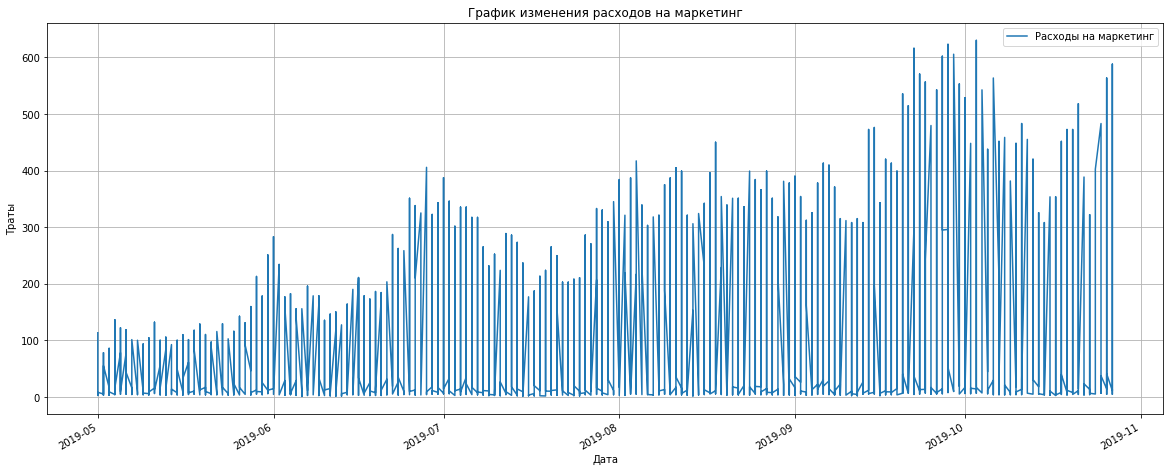

In [30]:
costs.plot(y='costs', # столбец значений для вертикальной оси,
           x='dt',
           figsize=(20, 8),
           grid=True,       
           label='Расходы на маркетинг',                   
           #legend=True
          ) 

plt.title('График изменения расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Траты')
plt.show()

На графике видно, что траты росли с течением времени.

Можно выделить несколько скачков:
* Конец июня - начало июля
* Середина сентября - середина октября (в этот период наблюдаются наибольшие затраты на маркетинг)
* Следом идет небольшой спад и снова график стремится вверх, но там нехватает данных

### Посчитаем сколько потратили на каждый источник

In [25]:
channel_costs_report = pd.DataFrame()
channel_costs_report['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs_report['share'] = ((channel_costs_report['costs'] / costs['costs'].sum()) * 100)
channel_costs_report.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

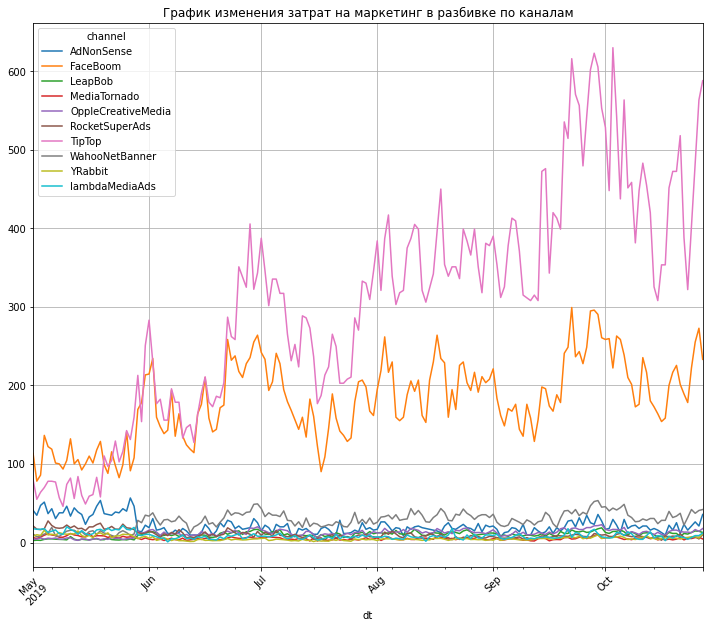

In [26]:
data = costs.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='sum'
)
data.plot(                                             
           figsize=(12, 10), # размеры картинки: (x_size, y_size)
           grid=True, # отображать сетку или нет
           rot=45,        
           label='Каналы', # название линии                       
           legend=True,# выводить ли легенду к графику
           #colormap='ocean'
) 
plt.title('График изменения затрат на маркетинг в разбивке по каналам')
plt.show()

* На графике четко отражены 2 очень активных канала, в которые вливают бюджет `tiptop` and `faceboom`, больше всего вливают в типтоп, но и динамика у этого канала неспокойная, со временем траты увеличиваются и достигают 600+
* В остальные каналы вливают сильно меньше

### Посчитаем  сколько в среднем стоило привлечение

In [27]:
profiles.describe()

user_id  acquisition_cost
count  9.356900e+04      93569.000000
mean   4.995116e+11          1.127481
std    2.881600e+11          0.990503
min    5.993260e+05          0.124615
25%    2.506301e+11          0.257143
50%    4.972331e+11          1.080531
75%    7.490889e+11          1.128571
max    9.999799e+11          3.715385

* Средняя стоимость привлечения равна ~1.1

Полагаю, что второй вариает оказался верным, средняя стоимость привлечения 1 клиента равна ~1,1

In [28]:
# Посмотрим на CAC для каждого источника трафика

cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

* Самый дорогой трафик - TipTop, далее идет FaceBoom и AdNonSense примерно в равной ценовой категории.
* Органический трафик бесплатен, остальные каналы берут за пользователя от 0.21 до 0.72 у.е.

## Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

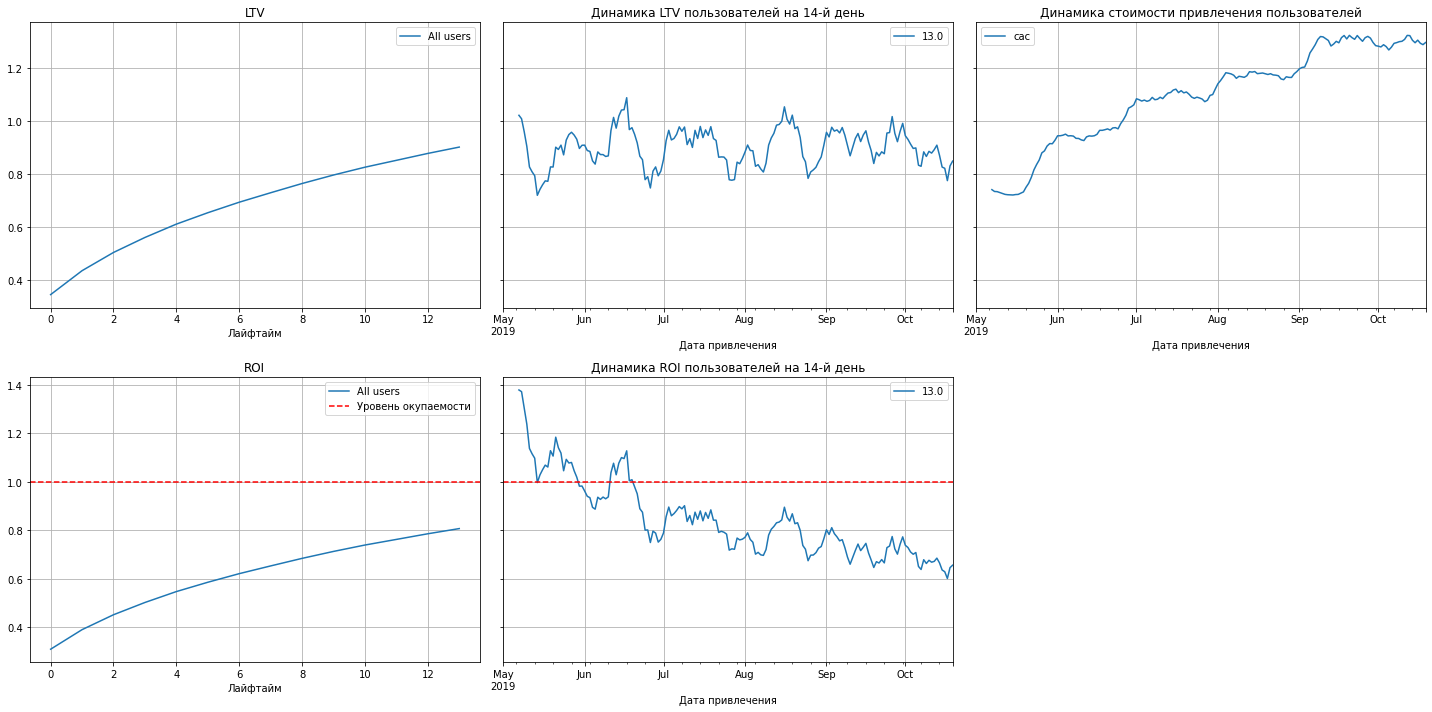

In [29]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Исходя из графиков можно сделать следующие выводы:
* Стоимость привлечения растет
* Реклама не окупается, к концу 2 недели ROI - 80%
* ROI пользователей падает, после середины июня стал ниже окупаемости

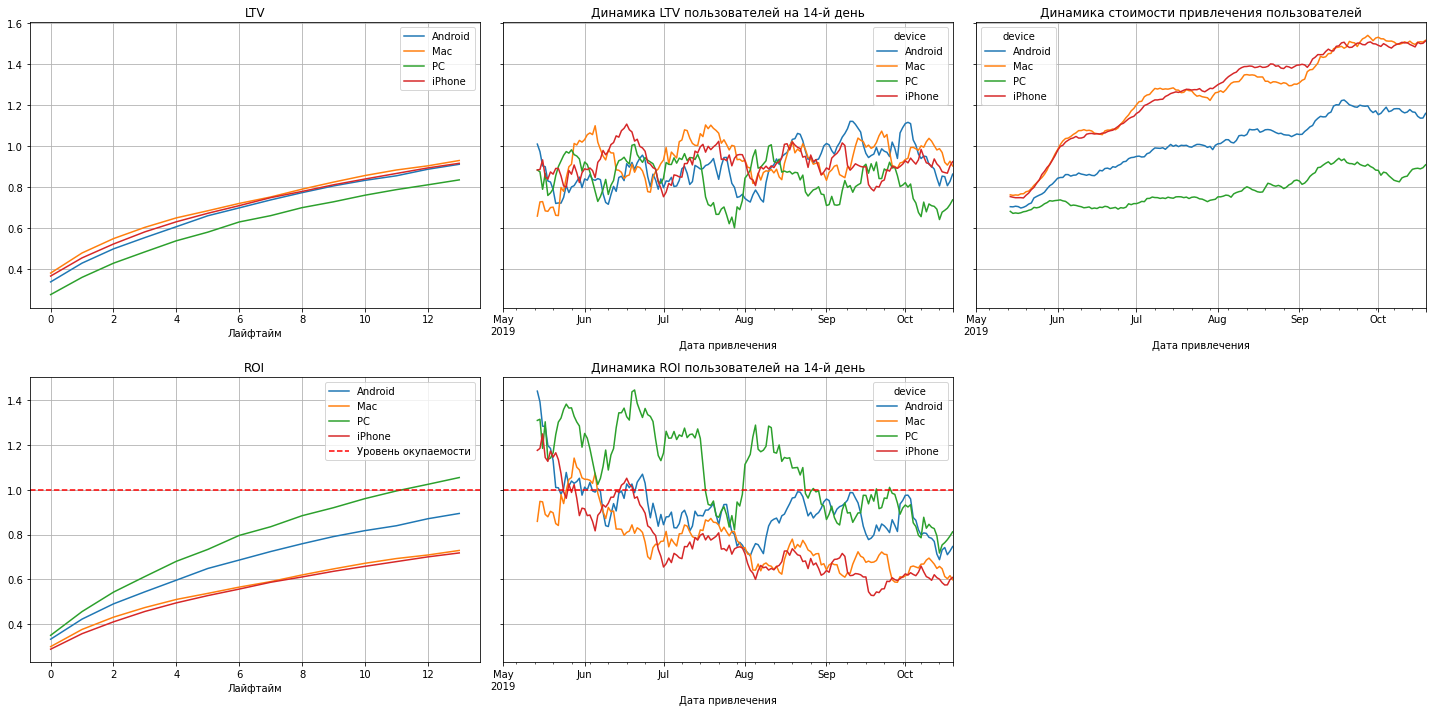

In [30]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

* Пользователи ПК окупались до сентября, остальные окупались до сентября, а потом пошли вниз, особенно пользователи продукции эпл, вероятнее всего из-за стоимости на рекламу
* Стоимость привлечения всех устройств растет со временем, сильнее всего растет стоимость привлечения пользователей продукции эпл, меньше всего тратится на пользователей ПК и не сильно растёт со временем
* ROI пользователей ПК находится на грани окупаемости по окончанию 2 недели

### Изучим конверсию и удержание с разбивкой по устройствам

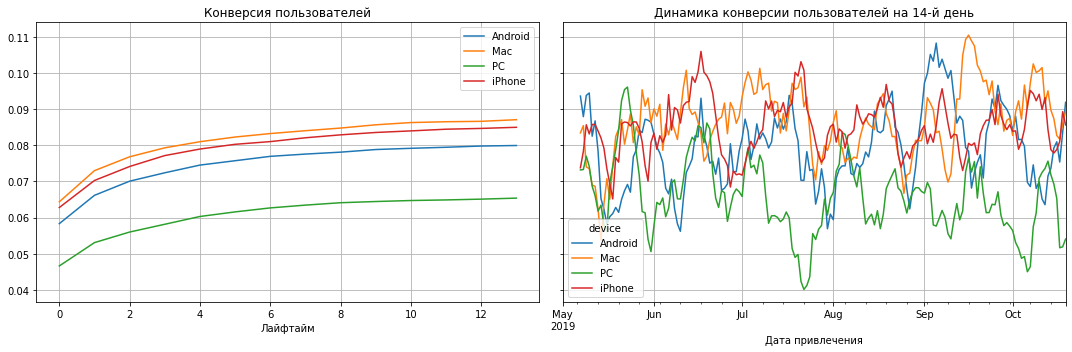

In [31]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи техники эпл хорошо конвертируют, чуть слабее пользователи андроида и совсем грустно пользователи ПК

Посмотрим на удержание

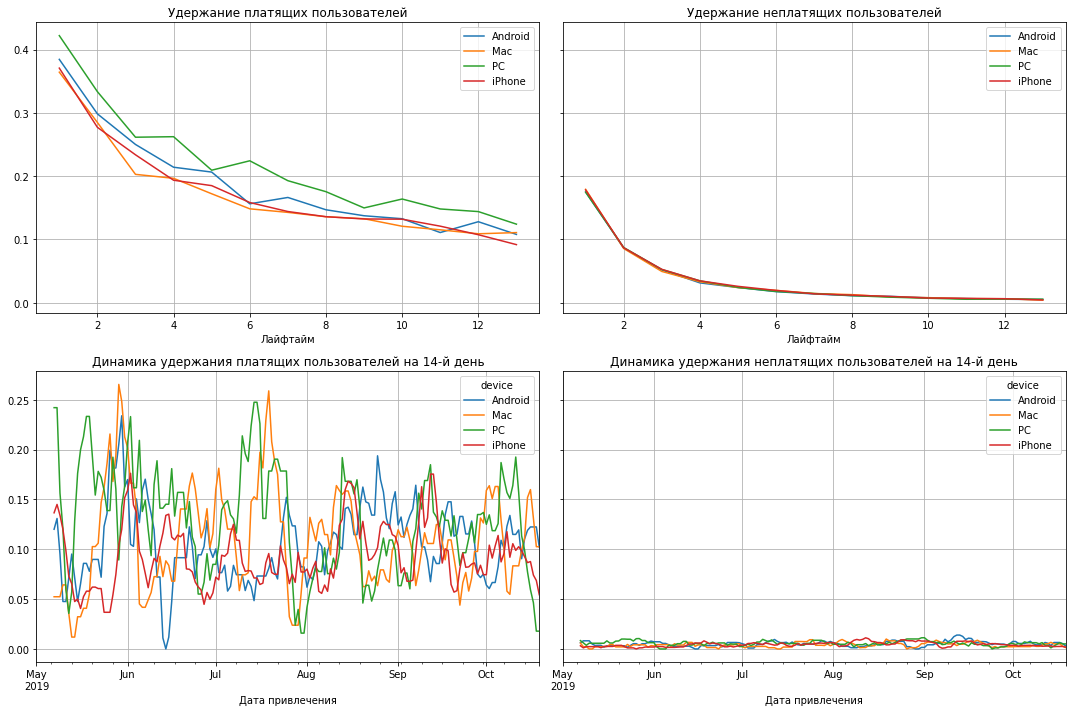

In [32]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

* Неплатящие пользователи удерживаются стабильно плохо
* Из платящих лучше всего удерживаются пользователи PC, хуже - владельцы iPhone и Mac.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

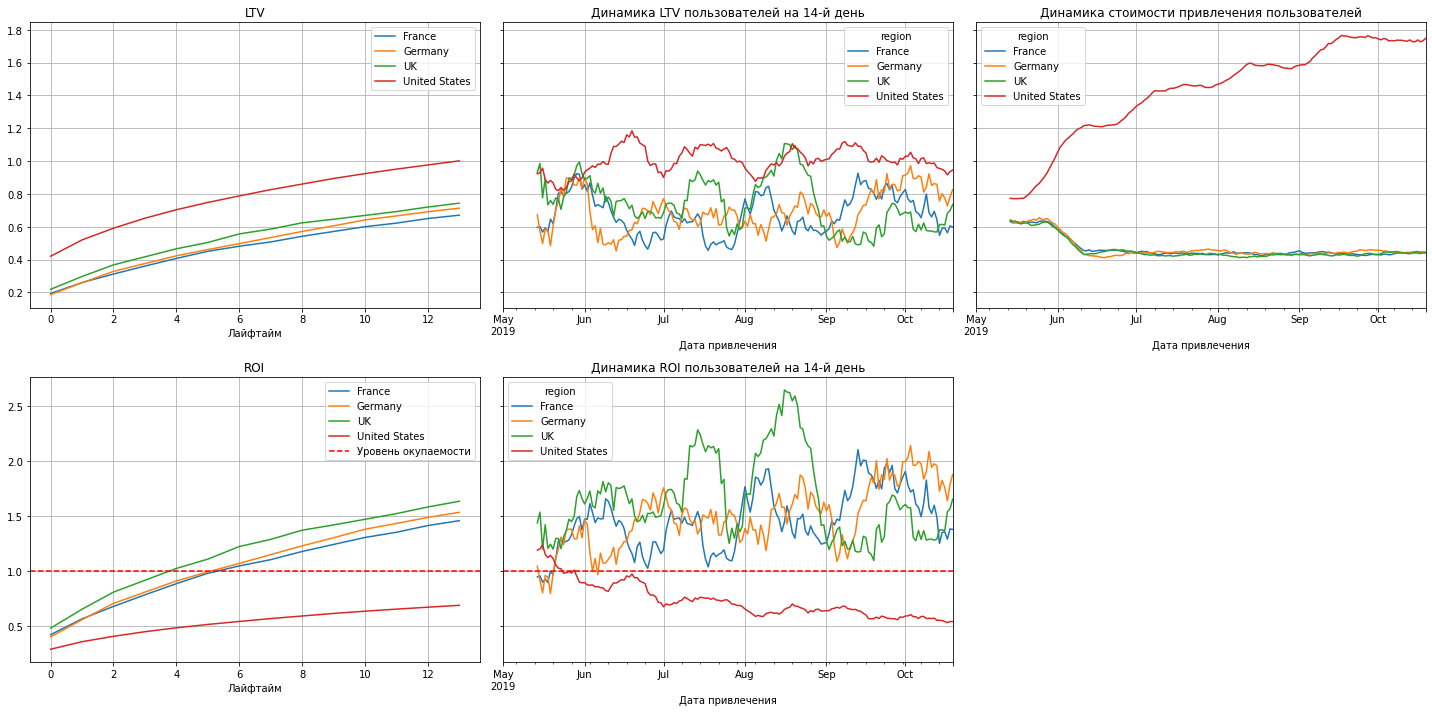

In [33]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

* Реклама не окупается в той стране, откуда у нас больше всего пользователей, из США
* Также стоимость привлечения в США самая высокая
* Лучше всего окупается Англия и Германия.

С США какие-то проблемы, возможно там уже есть похожий продукт или возникают какие-то сложности именно в США

Посмотрим на конверсию

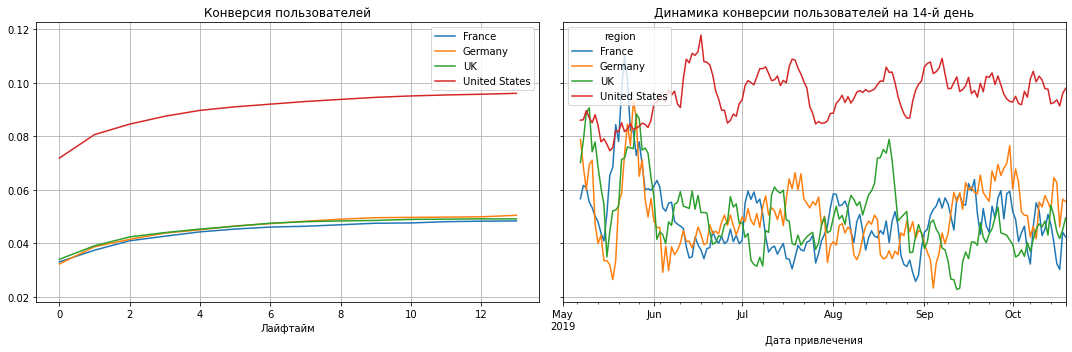

In [34]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

* У США все-таки самая высокая конверсия
* В остальных странах она самая низкая

Посмотрим на удержание

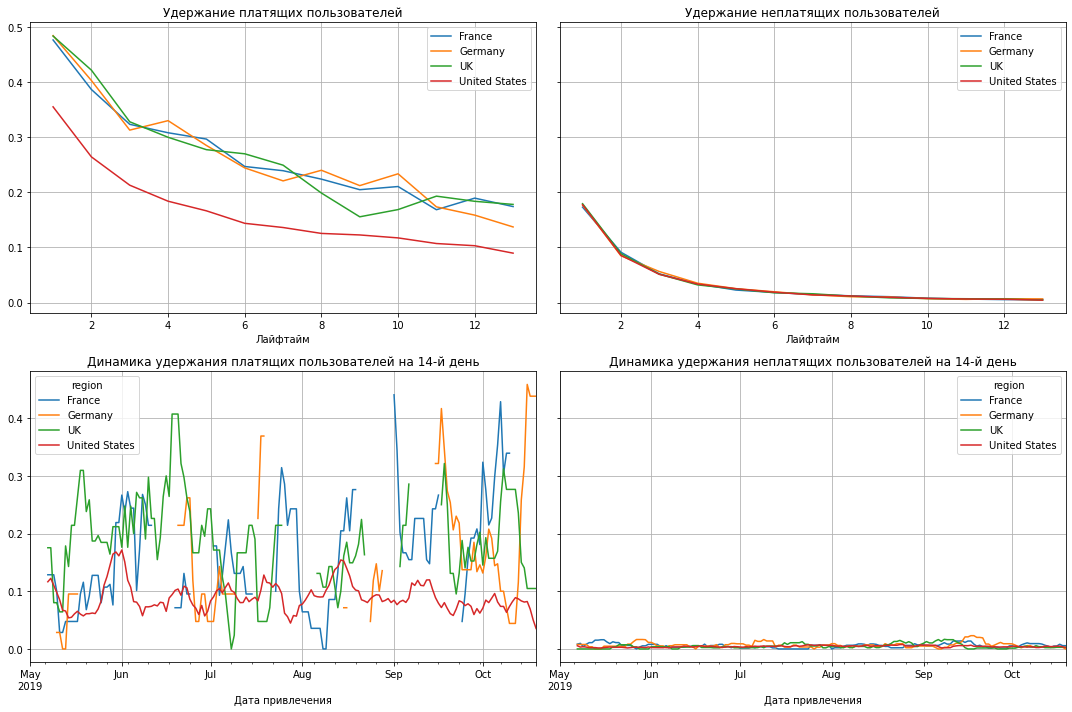

In [35]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

* Хуже всего удерживаются пользователи из США

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

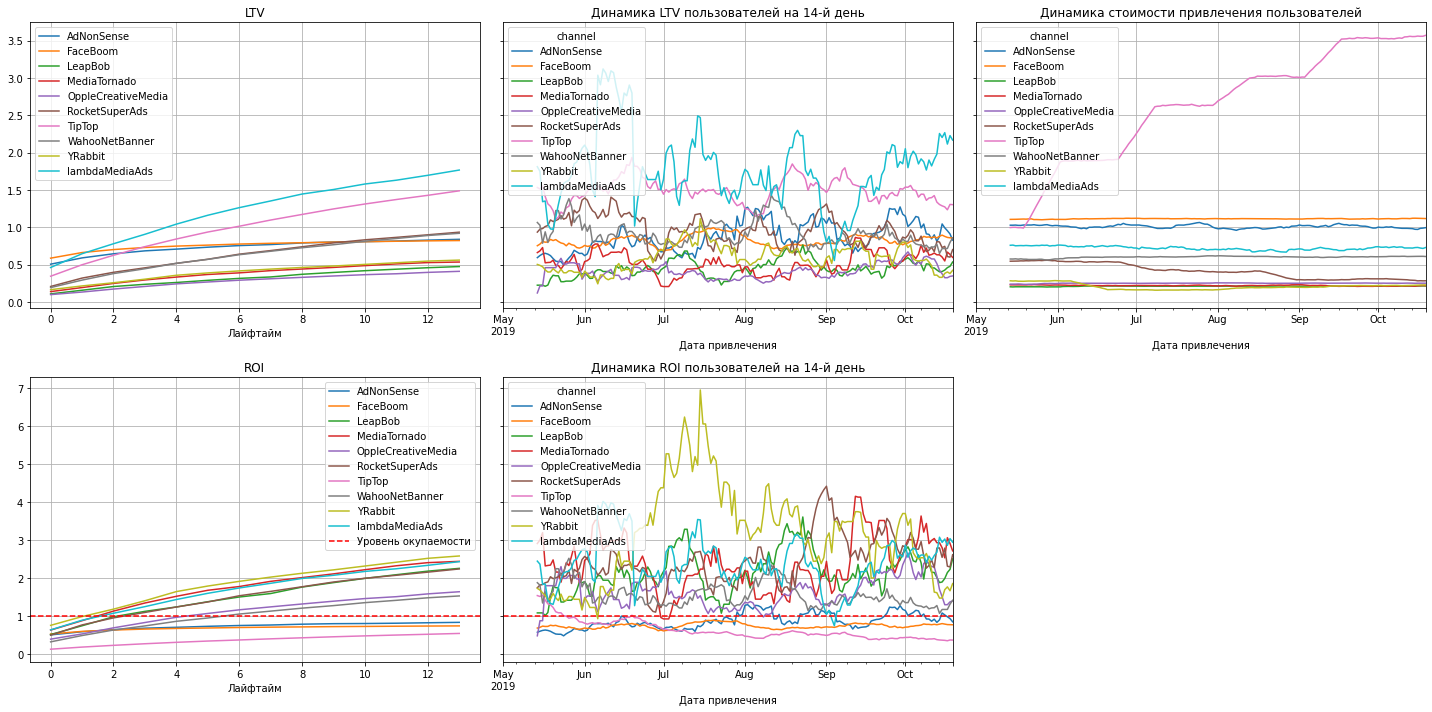

In [36]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

* Много стоит привлечение через канал TipTop, они не окупаются
* Вместе с TipTop не окупаются и FaceBoom, и AdNonSense
* Долгоиграющие пользователи приходят из lamdaMediaAds
* Лучшую окупаемость показал Yrabbit

Посмотрим на конверсию

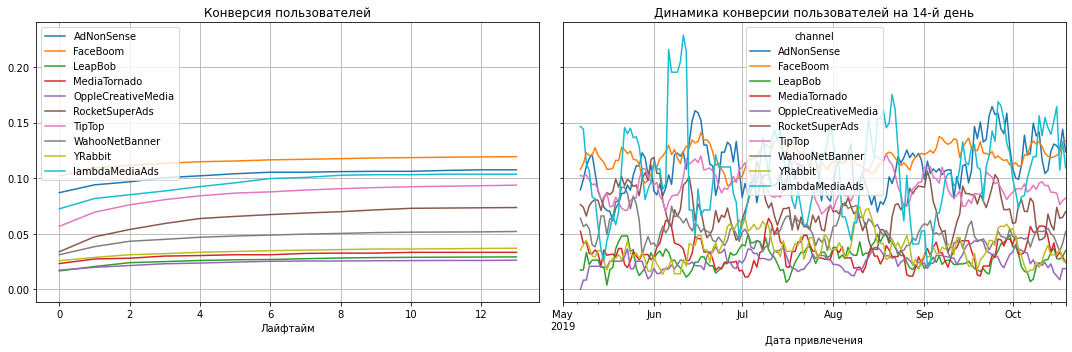

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

* Хорошо конвертируются пользователи из канала FaceBomb, но эти инвестиции не окупаются и стоят довольно много
* Следом идет AdNonSense, но там такая же история
* Потом lambdaMediaAds,  этот канал и окупается, из него приходят долгоиграющие пользователи и реклама стоит не очень дорого
* Хуже всего конвертируется из канала OppleCreativeMedia

Посмотрим на удержание

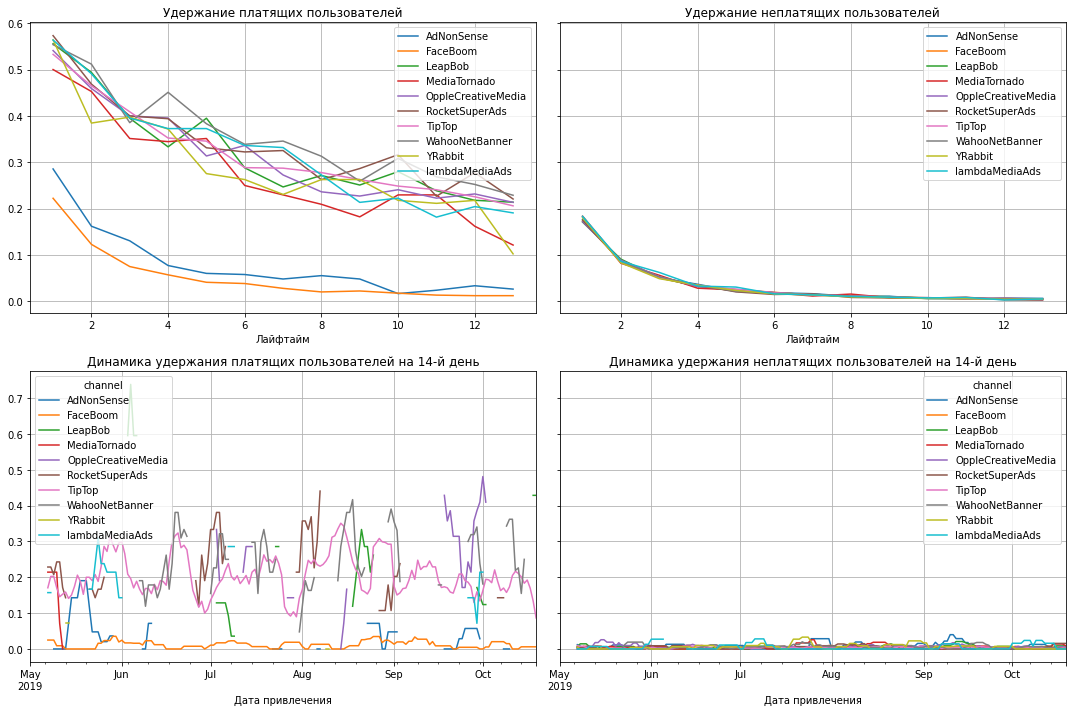

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

* FaceBoom и AdNonSense явно отстают

**Вывод**
* Реклама близка к окупаемости, ROI составляет 80% к концу 2 недели
* Не окупаются пользователи продукции эпл из США, привлеченные из каналов LeapBop, FaceBoom, TipTop.
* Очень много денег вкладывается в TipTop, хотя не окупаются.


## Выводы
**Выделите причины неэффективности привлечения пользователей**

`Устройства`
* Пользователи всех устройств окупались до июня, а потом что-то пошло не так, особенно для владельцев Mac и Iphone. К сентябрю (и какое-то время в августе) ROI пользователей PC на 14 день был на грани окупаемости, ROI всех остальных устройств был уже ниже уровня начиная с июня.

* Стоимость привлечения пользователей PC самая низкая, а ROI - наоборот, выше остальных. В целом, видим, что стоимость привлечения пользователей всех устройств росла за рассматриваемый период.

Направить внимание следует на владельцев Mac и iPhone - такие пользователи стоят дорого, а окупаемоcть страдает. Судя по графикам, пользователи Mac, Android и iPhone конвертируются неплохо. Не видно, чтобы пользователи каких-то определенных устройств особо плохо удерживались. Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи PC, хуже - владельцы iPhone и Mac.

`Страны`
* В США уровень окупаемости рекламы низкий, а стоимость высокая, но от туда у нас больше всего пользователей.
* Лучше всего окупается Англия и Германия, но у них слабая конверсия, но и доля не такая большая.
* Пользователи из США плохо удерживаются

Следует внимательнее присмотреться к США.

`Каналы`
* Большая стоимость привлечения пользователей из рекламного канала TipTop, но результатов не много.
* Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop.
* Хорошо показала себя рекламная сеть YRabbit в июле - ROI пользователей на 14 день был высок.
* Плохо конвертируются пользователи из каналов RocketSuperAds, MediaTornado, YRabbit.
* Видим явных аутсайдеров - плохо удерживаются пользователи из каналов FaceBoom и AdNonSense.

Стоит присмотреться к каналам LeapBop, FaceBoom, TipTop, стоит ли тратить столько денег на них.

**Сформируйте рекомендации для отдела маркетинга для повышения эффективности.**
* Стоит прицелиться на Германии, Англию и Францию, инвестиции окупаются и стоят не так дорого как США
* Также стоит посмотреть в сторону пользователей продукции эпл, стоят они дорого, а денег приносят не много. Возможно повысить для них тарифы или подготовить кампанию которая поспособствует окупаемости.
* Присмотреться к TipTop и порезать бюджет, результата от неё немного. Также стоит посмотреть на LeapBop, FaceBoom.
* Стоит уделить вниманию каналу lambdaMediaAds, этот канал и окупается, из него приходят долгоиграющие пользователи и реклама стоит не очень дорого